In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc, joblib
from pprint import pprint
import lightgbm as lgb
from sklearn import metrics
from functools import reduce
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedGroupKFold,
)
from contextlib import suppress

In [2]:
pathway = ""


def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        # Cast Transform DPD (Days past due, P) and Transform Amount (A) as Float64
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        # Cast Transform date (D) as Date, causes issues with other columns ending in D
        # if col[-1] in ("D"):
        # df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
        # Cast aggregated columns as Float64, tried combining sum and max, but did not work correctly
        if col[-4:-1] in ("_sum"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
        if col[-4:-1] in ("_max"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
    return df


def convert_strings(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            df = df.with_columns(pl.col(col).cast(pl.Categorical))
    return df


# Changed this function to work for Pandas
def missing_values(df, threshold=0.0):
    missing_cols = []
    for col in df.columns:
        decimal = (pd.isnull(df[col]).sum()) / (len(df[col]))
        if decimal > threshold:
            print(f"{col}: {decimal}")
            missing_cols.append(col)
    return missing_cols


# Impute numeric columns with the median and cat with mode
def imputer(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = df[col].fillna(df[col].median())
        if df[col].dtype.name in ["category", "object"] and df[col].isnull().any():
            mode_without_nan = df[col].dropna().mode().values[0]
            df[col] = df[col].fillna(mode_without_nan)
    return df

In [4]:
train = (
    pl.read_csv("train_final_final.csv").pipe(set_table_dtypes).pipe(convert_strings)
)
train.head()

maxoutstandbalancel12m_4187113A,maxdebt4_972A,lastapplicationdate_877D_diff,disbursementtype_67L,numinstregularpaid_973L,currdebtcredtyperange_828A,case_id,pmts_overdue_1140A_sum_right,opencred_647L,numinstpaidearly3dest_4493216L,numberofoutstandinstls_520L_sum,credtype_587L,numinstpaid_4499208L,credtype_322L,empls_economicalst_849M,safeguarantyflag_411L,byoccupationinc_3656910L_max,credacc_credlmt_575A_max,dtlastpmtallstes_4499206D_diff,numpmtchanneldd_318L,conts_type_509L,clientscnt_360L,tenor_203L_sum,dpdmax_139P_max,numinstpaidearly_338L,pmts_dpd_303P_sum,applicationscnt_629L,maxinstallast24m_3658928A,monthsannuity_845L,lastapprcredamount_781A,maxlnamtstart6m_4525199A,numactivecredschannel_414L,downpmt_116A,applicationscnt_867L,posfpd30lastmonth_3976960P,mobilephncnt_593L,mindbdtollast24m_4525191P,…,pctinstlsallpaidlate4d_3546849L,isbidproduct_390L,addres_zip_823M,totinstallast1m_4525188A,cntincpaycont9m_3716944L,numinstregularpaidest_4493210L,sex_738L,numberofoverdueinstlmax_1151L_sum,avginstallast24m_3658937A,dateofbirth_337D_diff,isbidproduct_1095L,maxdpdlast24m_143P,maritalst_385M,clientscnt_1130L,equalitydataagreement_891L,datelastinstal40dpd_247D,numinstlswithdpd10_728L,avgdbddpdlast3m_4187120P,overdueamountmax2_398A_max,sellerplacecnt_915L,familystate_447L,clientscnt3m_3712950L,posfstqpd30lastmonth_3976962P,status_219L,days360_512L,maxdpdinstlnum_3546846P,pmts_dpd_1073P_sum,birth_259D_diff,clientscnt_304L,lastactivateddate_801D_diff,isdebitcard_729L,dpdmax_757P_max,maxdpdlast12m_727P,type_25L,overdueamountmax_35A_max,numinstmatpaidtearly2d_4499204L,target
f64,f64,f64,cat,f64,f64,i64,f64,i64,f64,f64,cat,f64,cat,cat,i64,f64,f64,f64,f64,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,i64,cat,f64,f64,f64,cat,f64,f64,f64,i64,f64,cat,f64,i64,cat,f64,f64,f64,f64,cat,f64,f64,cat,f64,f64,f64,f64,f64,f64,i64,f64,f64,cat,f64,f64,i64
42520.402,0.0,217.0,"""GBA""",18.0,0.0,0,0.0,0,12.0,0.0,"""COL""",22.0,"""CAL""","""a55475b1""",1,15000.0,0.0,-13.0,0.0,"""PRIMARY_MOBILE…",0.0,48.0,0.0,9.0,0.0,0.0,6648.6,18.0,24774.0,32934.6,0.0,0.0,0.0,0.0,1.0,-17.0,…,0.01695,0,"""a55475b1""",6221.2,5.0,22.0,"""F""",1.0,4068.6,12099.0,0,0.0,"""a55475b1""",0.0,1,"""2020-06-15""",0.0,-4.0,3292.6,0.0,"""MARRIED""",0.0,0.0,"""D""",3.0,7.0,0.0,11874.0,0.0,306.0,0,10.0,0.0,"""PRIMARY_MOBILE…",3016.39415,13.0,0
42520.402,0.0,217.0,"""GBA""",18.0,0.0,1,0.0,0,12.0,0.0,"""COL""",22.0,"""CAL""","""a55475b1""",1,15000.0,0.0,-13.0,0.0,"""PRIMARY_MOBILE…",0.0,48.0,0.0,9.0,0.0,0.0,6648.6,18.0,24774.0,32934.6,0.0,0.0,0.0,0.0,1.0,-17.0,…,0.01695,0,"""a55475b1""",6221.2,5.0,22.0,"""M""",1.0,4068.6,12099.0,0,0.0,"""a55475b1""",0.0,1,"""2020-06-15""",0.0,-4.0,3292.6,0.0,"""DIVORCED""",0.0,0.0,"""D""",3.0,7.0,0.0,22435.0,0.0,306.0,0,10.0,0.0,"""PRIMARY_MOBILE…",3016.39415,13.0,0
42520.402,0.0,2102.0,"""GBA""",18.0,0.0,2,0.0,0,12.0,0.0,"""CAL""",22.0,"""CAL""","""a55475b1""",1,15000.0,0.0,-13.0,0.0,"""PRIMARY_MOBILE…",0.0,36.0,0.0,9.0,0.0,0.0,6648.6,18.0,24774.0,32934.6,0.0,0.0,0.0,0.0,2.0,-17.0,…,0.01695,0,"""a55475b1""",6221.2,5.0,22.0,"""F""",1.0,4068.6,12099.0,0,0.0,"""a55475b1""",0.0,1,"""2020-06-15""",0.0,-4.0,3292.6,0.0,"""MARRIED""",0.0,0.0,"""D""",3.0,7.0,0.0,16105.0,0.0,306.0,0,10.0,0.0,"""PRIMARY_MOBILE…",3016.39415,13.0,0
42520.402,0.0,-4.0,"""GBA""",18.0,0.0,3,0.0,0,12.0,0.0,"""CAL""",22.0,"""CAL""","""a55475b1""",1,15000.0,0.0,-13.0,0.0,"""PHONE""",0.0,12.0,0.0,9.0,0.0,0.0,6648.6,18.0,24774.0,32934.6,0.0,0.0,1.0,0.0,1.0,-17.0,…,0.01695,0,"""a55475b1""",6221.2,5.0,22.0,"""F""",1.0,4068.6,12099.0,0,0.0,"""a55475b1""",1.0,1,"""2020-06-15""",0.0,-4.0,3292.6,1.0,"""MARRIED""",0.0,0.0,"""D""",3.0,7.0,0.0,9286.0,0.0,306.0,0,10.0,0.0,"""PRIMARY_MOBILE…",3016.39415,13.0,0
42520.402,0.0,-4.0,"""GBA""",18.0,0.0,4,0.0,0,12.0,0.0,"""CAL""",22.0,"""CAL""","""a55475b1""",1,15000.0,0.0,-13.0,0.0,"""PRIMARY_MOBILE…",0.0,24.0,0.0,9.0,0.0,0.0,6648.6,18.0,24774.0,32934.6,0.0,0.0,1.0,0.0,1.0,-17.0,…,0.01695,0,"""a55475b1""",6221.2,5.0,22.0,"""F""",

In [5]:
test = pl.read_csv("test_final_final.csv").pipe(set_table_dtypes).pipe(convert_strings)
test.head()

maxoutstandbalancel12m_4187113A,maxdebt4_972A,lastapplicationdate_877D_diff,disbursementtype_67L,numinstregularpaid_973L,currdebtcredtyperange_828A,case_id,pmts_overdue_1140A_sum_right,opencred_647L,numinstpaidearly3dest_4493216L,numberofoutstandinstls_520L_sum,credtype_587L,numinstpaid_4499208L,credtype_322L,empls_economicalst_849M,safeguarantyflag_411L,byoccupationinc_3656910L_max,credacc_credlmt_575A_max,dtlastpmtallstes_4499206D_diff,numpmtchanneldd_318L,conts_type_509L,clientscnt_360L,tenor_203L_sum,dpdmax_139P_max,numinstpaidearly_338L,pmts_dpd_303P_sum,applicationscnt_629L,maxinstallast24m_3658928A,monthsannuity_845L,lastapprcredamount_781A,maxlnamtstart6m_4525199A,numactivecredschannel_414L,downpmt_116A,applicationscnt_867L,posfpd30lastmonth_3976960P,mobilephncnt_593L,mindbdtollast24m_4525191P,…,maxdpdtolerance_577P_max,pctinstlsallpaidlate4d_3546849L,isbidproduct_390L,addres_zip_823M,totinstallast1m_4525188A,cntincpaycont9m_3716944L,numinstregularpaidest_4493210L,sex_738L,numberofoverdueinstlmax_1151L_sum,avginstallast24m_3658937A,dateofbirth_337D_diff,isbidproduct_1095L,maxdpdlast24m_143P,maritalst_385M,clientscnt_1130L,equalitydataagreement_891L,datelastinstal40dpd_247D,numinstlswithdpd10_728L,avgdbddpdlast3m_4187120P,overdueamountmax2_398A_max,sellerplacecnt_915L,familystate_447L,clientscnt3m_3712950L,posfstqpd30lastmonth_3976962P,status_219L,days360_512L,maxdpdinstlnum_3546846P,pmts_dpd_1073P_sum,birth_259D_diff,clientscnt_304L,lastactivateddate_801D_diff,isdebitcard_729L,dpdmax_757P_max,maxdpdlast12m_727P,type_25L,overdueamountmax_35A_max,numinstmatpaidtearly2d_4499204L
f64,f64,f64,cat,f64,f64,i64,f64,i64,f64,f64,cat,f64,cat,cat,i64,f64,f64,f64,f64,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,i64,cat,f64,f64,f64,cat,f64,f64,f64,i64,f64,cat,f64,i64,cat,f64,f64,f64,f64,cat,f64,f64,cat,f64,f64,f64,f64,f64,f64,i64,f64,f64,cat,f64,f64
157731.78,231440.03,41.0,"""GBA""",96.0,0.0,57543,0.0,0,34.0,0.0,"""CAL""",96.0,"""CAL""","""a55475b1""",0,15000.0,0.0,-1.0,0.0,"""PRIMARY_MOBILE…",0.0,164.0,0.0,25.0,0.0,0.0,131700.8,66.0,14000.0,16672.6,0.0,0.0,9.0,0.0,2.0,-7.0,…,50.0,0.07292,0,"""a55475b1""",17859.6,5.0,96.0,"""F""",34.0,16049.4,14804.0,1,7.0,"""38c061ee""",0.0,1,"""2020-05-28""",0.0,2.0,3271.6882,0.0,"""SINGLE""",0.0,0.0,"""K""",8.0,14.0,0.0,14804.0,0.0,18.0,0,20.0,3.0,"""PRIMARY_MOBILE…",3271.6882,37.0
21278.0,34066.0,-10.0,"""GBA""",44.0,10638.2,57549,0.0,0,15.0,0.0,"""CAL""",44.0,"""CAL""","""a55475b1""",1,50000.0,34066.0,161.0,0.0,"""PRIMARY_MOBILE…",0.0,91.0,0.0,15.0,0.0,0.0,122511.4,41.0,94000.0,31820.6,0.0,0.0,10.0,0.0,3.0,-2.0,…,1.0,0.18605,1,"""a55475b1""",126058.0,3.0,44.0,"""F""",310.0,32426.201,22723.0,1,0.0,"""a7fcb6e5""",0.0,1,"""2020-05-28""",15.0,0.0,48690.402,2.0,"""SINGLE""",0.0,0.0,"""K""",12.0,16.0,0.0,22723.0,0.0,-10.0,0,108.0,0.0,"""PRIMARY_MOBILE…",48690.402,15.0
62619.0,54000.0,14.0,"""SBA""",9.0,0.0,57551,0.0,0,3.0,0.0,"""CAL""",9.0,"""COL""","""a55475b1""",0,32500.0,17033.0,161.0,0.0,"""PRIMARY_MOBILE…",0.0,127.5,0.0,0.0,0.0,0.0,41783.402,9.0,200000.0,54000.0,0.0,0.0,2.0,0.0,1.0,-4.0,…,25.5,0.11111,0,"""a55475b1""",18374.3,4.0,9.0,"""F""",4.0,8357.2,14090.0,0,4.0,"""3439d993""",0.0,1,"""2020-05-28""",0.0,-3.0,10429.616,1.0,"""SINGLE""",0.0,0.0,"""K""",4.0,6.0,0.0,14090.0,0.0,405.0,0,3.0,4.0,"""PRIMARY_MOBILE…",10429.616,5.0
288642.6,188126.14,80.0,"""GBA""",32.0,191269.61,57552,0.0,0,26.0,0.0,"""CAL""",32.0,"""CAL""","""a55475b1""",1,32500.0,17033.0,161.0,0.0,"""PRIMARY_MOBILE…",0.0,127.5,0.0,24.0,0.0,0.0,12155.4,23.0,0.0,104473.6,0.0,0.0,9.0,0.0,1.0,-13.0,…,25.5,0.0,0,"""a55475b1""",18889.0,18.0,32.0,"""M""",19.0,7440.4,23768.0,1,0.0,"""a55475b1""",0.0,1,"""2020-05-28""",0.0,-7.0,6850.6521,0.0,"""SINGLE""",0.0,0.0,"""K""",5.0,7.0,0.0,23768.0,0.0,234.0,0,11.5,0.0,"""PRIMARY_MOBILE…",6850.6521,27.0
0.0,64555.668,-14.0,"""GBA""",15.0,0.0,57569,0.0,1,5.0,0.0,"""CAL""",15.0,"""CAL""","""P148_57_109""",0,32500.0,17033.0,209.0,0.0,"""PRIMARY_MOBILE…",0.0,127.5,0.0,

In [6]:
# change train and test to pandas
train = train.to_pandas()
test = test.to_pandas()

In [7]:
y = train.loc[:, "target"].to_frame("target")
X = train.drop(
    [
        "target",
    ],
    axis=1,
)

# Do not include case_id, or week_num as numeric
numeric_cols = test.select_dtypes(include=["number"]).columns.tolist()
numeric_cols.remove("case_id")
numeric_cols.remove("WEEK_NUM")


# scale values before passing on to model
warnings.filterwarnings("ignore")
scaler = MinMaxScaler(copy=False)
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

# Drop case_id and week_num from features
weeks = X["WEEK_NUM"]
X_feats = X.drop(["case_id", "WEEK_NUM"], axis=1)

# Sort columns in alphabetical order for training so columns match test submission
X_feats = X_feats.reindex(sorted(X_feats.columns), axis=1)

# LGB TUNING

In [18]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = (
        base.loc[:, ["WEEK_NUM", "target", "score"]]
        .sort_values("WEEK_NUM")
        .groupby("WEEK_NUM")[["target", "score"]]
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1)
        .tolist()
    )

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

### Tune Max Depth

In [25]:
%%time
warnings.filterwarnings("ignore")
cv = StratifiedGroupKFold(n_splits=2, shuffle=True)

cv_plot_series = []
stab_plot_series = []

# Note: uncomment device when running with GPU P100 accelerator
max_depths = [5,10,15,20,25,30,35]
for max_depth in max_depths:
    fitted_models = []
    cv_scores = []
    stab_scores = []

    grid_params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": max_depth,
        "learning_rate": 0.05,
        "n_estimators": 500,
        "colsample_bytree": 0.8,
        "colsample_bynode": 0.8,
        "random_state": 42,
        "reg_alpha": 0.1,
        "reg_lambda": 10,
        "extra_trees":True,
        'num_leaves':64,
        "verbose": -1,
        "max_bin": 250,
        #'device':'gpu',
    }

    for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
        X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
        
        clf = lgb.LGBMClassifier(**grid_params)
        clf.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)])
        fitted_models.append(clf)
        
        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores.append(auc_score)

        base_valid = pd.concat([X_valid, y_valid], axis=1)
        base_valid["score"] = clf.predict_proba(X_valid)[:, 1]
        base_train = pd.concat([X_train, y_train], axis=1)
        base_train["score"] = clf.predict_proba(X_train)[:, 1]
        base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]
        base_train["WEEK_NUM"] = weeks.iloc[idx_train]

        stability_score_train = gini_stability(base_train)
        print(f"The stability score on the train set is: {stability_score_train}")
        stability_score_valid = gini_stability(base_valid)
        print(f"The stability score on the valid set is: {stability_score_valid}")
        stab_scores.append(stability_score_valid)


    print("CV AUC scores: ", cv_scores)
    print("Maximum CV AUC score: ", max(cv_scores))
    cv_plot_series.append(max(cv_scores))

    print("CV Stability scores: ", stab_scores)
    print("Maximum CV Stability score: ", max(stab_scores))
    stab_plot_series.append(max(stab_scores))

    warnings.filterwarnings("default")

print(cv_plot_series)
print(stab_plot_series)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.82645
[400]	valid_0's auc: 0.832566
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.834176
The stability score on the train set is: 0.6889129812024511
The stability score on the valid set is: 0.6469907732263238
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.825606
[400]	valid_0's auc: 0.831203
Did not meet early stopping. Best iteration is:
[497]	valid_0's auc: 0.832435
The stability score on the train set is: 0.6937518282493248
The stability score on the valid set is: 0.6528336605502332
CV AUC scores:  [0.8341762636506496, 0.8324352599730138]
Maximum CV AUC score:  0.8341762636506496
CV Stability scores:  [0.6469907732263238, 0.6528336605502332]
Maximum CV Stability score:  0.6528336605502332


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.836017
[400]	valid_0's auc: 0.840425
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.841407
The stability score on the train set is: 0.746570149282222
The stability score on the valid set is: 0.6619299148072086


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.828653
[400]	valid_0's auc: 0.833805
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.835019
The stability score on the train set is: 0.748623203375167
The stability score on the valid set is: 0.652787219910012
CV AUC scores:  [0.8414067997955123, 0.8350188315998025]
Maximum CV AUC score:  0.8414067997955123
CV Stability scores:  [0.6619299148072086, 0.652787219910012]
Maximum CV Stability score:  0.6619299148072086


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.834703
[400]	valid_0's auc: 0.839644
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.840509
The stability score on the train set is: 0.7560925618980658
The stability score on the valid set is: 0.6590587653558917


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.832017
[400]	valid_0's auc: 0.836876
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.837566
The stability score on the train set is: 0.7476162859793426
The stability score on the valid set is: 0.6603695638051648
CV AUC scores:  [0.8405094548875744, 0.8375662372917568]
Maximum CV AUC score:  0.8405094548875744
CV Stability scores:  [0.6590587653558917, 0.6603695638051648]
Maximum CV Stability score:  0.6603695638051648


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.832298
[400]	valid_0's auc: 0.837243
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.838147
The stability score on the train set is: 0.7519663132198364
The stability score on the valid set is: 0.6585063205773041


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.834543
[400]	valid_0's auc: 0.839158
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.839952
The stability score on the train set is: 0.7521650409100827
The stability score on the valid set is: 0.6614211015613437
CV AUC scores:  [0.838146679736026, 0.8399522151755858]
Maximum CV AUC score:  0.8399522151755858
CV Stability scores:  [0.6585063205773041, 0.6614211015613437]
Maximum CV Stability score:  0.6614211015613437


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.832718
[400]	valid_0's auc: 0.83716
Did not meet early stopping. Best iteration is:
[499]	valid_0's auc: 0.837986
The stability score on the train set is: 0.7552695893131137
The stability score on the valid set is: 0.6585888379057141


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.83357
[400]	valid_0's auc: 0.838376
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.839028
The stability score on the train set is: 0.7486792225547588
The stability score on the valid set is: 0.6587303336737969
CV AUC scores:  [0.8379857799634888, 0.8390275114372047]
Maximum CV AUC score:  0.8390275114372047
CV Stability scores:  [0.6585888379057141, 0.6587303336737969]
Maximum CV Stability score:  0.6587303336737969


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.831403
[400]	valid_0's auc: 0.836592
Did not meet early stopping. Best iteration is:
[499]	valid_0's auc: 0.837424
The stability score on the train set is: 0.7533590575068498
The stability score on the valid set is: 0.6547656500315692


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.836046
[400]	valid_0's auc: 0.840824
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.841678
The stability score on the train set is: 0.751039211762031
The stability score on the valid set is: 0.666399917997254
CV AUC scores:  [0.8374235581999732, 0.8416775422856351]
Maximum CV AUC score:  0.8416775422856351
CV Stability scores:  [0.6547656500315692, 0.666399917997254]
Maximum CV Stability score:  0.666399917997254


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.830469
[400]	valid_0's auc: 0.835327
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.836097
The stability score on the train set is: 0.7594332573262678
The stability score on the valid set is: 0.6573258728256813


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.836384
[400]	valid_0's auc: 0.841489
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.84218
The stability score on the train set is: 0.7447337759533557
The stability score on the valid set is: 0.6638669386585805
CV AUC scores:  [0.8360965742819604, 0.8421796921423392]
Maximum CV AUC score:  0.8421796921423392
CV Stability scores:  [0.6573258728256813, 0.6638669386585805]
Maximum CV Stability score:  0.6638669386585805
[0.8341762636506496, 0.8414067997955123, 0.8405094548875744, 0.8399522151755858, 0.8390275114372047, 0.8416775422856351, 0.8421796921423392]
[0.6528336605502332, 0.6619299148072086, 0.6603695638051648, 0.6614211015613437, 0.6587303336737969, 0.666399917997254, 0.6638669386585805]
CPU times: user 2h 55min 26s, sys: 11min 29s, total: 3h 6min 55s
Wall time: 38min 24s


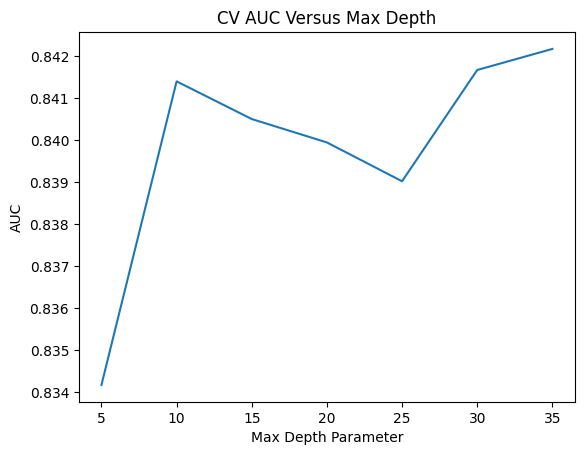

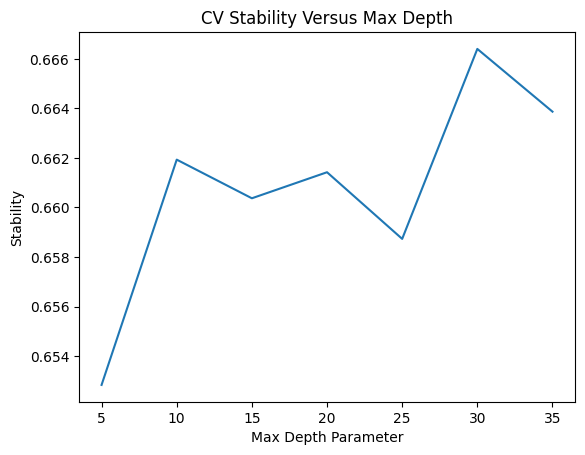

In [28]:
plt.plot(max_depths, cv_plot_series)
plt.title("CV AUC Versus Max Depth")
plt.ylabel("AUC")
plt.xlabel("Max Depth Parameter")
plt.show()

plt.plot(max_depths, stab_plot_series)
plt.title("CV Stability Versus Max Depth")
plt.ylabel("Stability")
plt.xlabel("Max Depth Parameter")
plt.show()

##### Clearly from looking at the two graphs, the best choice for maximizing stability and AUC is a max depth of 30

### Tune N_Estimators (update max depth param first)

In [29]:
%%time
warnings.filterwarnings("ignore")
cv = StratifiedGroupKFold(n_splits=2, shuffle=True)

cv_plot_series = []
stab_plot_series = []

# Note: uncomment device when running with GPU P100 accelerator
n_estimators = [350,500,650,800,950,1100]
for n_est in n_estimators:
    fitted_models = []
    cv_scores = []
    stab_scores = []

    grid_params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": 30,
        "learning_rate": 0.05,
        "n_estimators": n_est,
        "colsample_bytree": 0.8,
        "colsample_bynode": 0.8,
        "random_state": 42,
        "reg_alpha": 0.1,
        "reg_lambda": 10,
        "extra_trees":True,
        'num_leaves':64,
        "verbose": -1,
        "max_bin": 250,
        #'device':'gpu',
    }

    for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
        X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
        
        clf = lgb.LGBMClassifier(**grid_params)
        clf.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)])
        fitted_models.append(clf)
        
        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores.append(auc_score)

        base_valid = pd.concat([X_valid, y_valid], axis=1)
        base_valid["score"] = clf.predict_proba(X_valid)[:, 1]
        base_train = pd.concat([X_train, y_train], axis=1)
        base_train["score"] = clf.predict_proba(X_train)[:, 1]
        base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]
        base_train["WEEK_NUM"] = weeks.iloc[idx_train]

        stability_score_train = gini_stability(base_train)
        print(f"The stability score on the train set is: {stability_score_train}")
        stability_score_valid = gini_stability(base_valid)
        print(f"The stability score on the valid set is: {stability_score_valid}")
        stab_scores.append(stability_score_valid)


    print("CV AUC scores: ", cv_scores)
    print("Maximum CV AUC score: ", max(cv_scores))
    cv_plot_series.append(max(cv_scores))

    print("CV Stability scores: ", stab_scores)
    print("Maximum CV Stability score: ", max(stab_scores))
    stab_plot_series.append(max(stab_scores))

    warnings.filterwarnings("default")

print(cv_plot_series)
print(stab_plot_series)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.834436
Did not meet early stopping. Best iteration is:
[350]	valid_0's auc: 0.838376
The stability score on the train set is: 0.735146867795675
The stability score on the valid set is: 0.6591598144842593
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.832896
Did not meet early stopping. Best iteration is:
[350]	valid_0's auc: 0.837301
The stability score on the train set is: 0.724642032920973
The stability score on the valid set is: 0.6553860101782194
CV AUC scores:  [0.8383761370085114, 0.8373006875925291]
Maximum CV AUC score:  0.8383761370085114
CV Stability scores:  [0.6591598144842593, 0.6553860101782194]
Maximum CV Stability score:  0.6591598144842593


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.833173
[400]	valid_0's auc: 0.838239
Did not meet early stopping. Best iteration is:
[493]	valid_0's auc: 0.839164
The stability score on the train set is: 0.755265482068478
The stability score on the valid set is: 0.658507313007911


/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/adlerviton/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.834605
[400]	valid_0's auc: 0.839265
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.840014


In [ ]:
plt.plot(n_estimators, cv_plot_series)
plt.title("CV AUC Versus N_estimators")
plt.ylabel("AUC")
plt.xlabel("N_estimators Parameter")
plt.show()

plt.plot(n_estimators, stab_plot_series)
plt.title("CV Stability Versus N_estimators")
plt.ylabel("Stability")
plt.xlabel("N_estimators Parameter")
plt.show()

##### Based on the graphs above, the best choice for n_estimators is:

### Tune Number of Leaves (update n_estimators first)

In [ ]:
%%time
warnings.filterwarnings("ignore")
cv = StratifiedGroupKFold(n_splits=2, shuffle=True)

cv_plot_series = []
stab_plot_series = []

# Note: uncomment device when running with GPU P100 accelerator
num_leaves = [50,64,80,95,110]
for n_leaves in num_leaves:
    fitted_models = []
    cv_scores = []
    stab_scores = []

    grid_params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": 30,
        "learning_rate": 0.05,
        "n_estimators": 500,
        "colsample_bytree": 0.8,
        "colsample_bynode": 0.8,
        "random_state": 42,
        "reg_alpha": 0.1,
        "reg_lambda": 10,
        "extra_trees":True,
        'num_leaves': n_leaves,
        "verbose": -1,
        "max_bin": 250,
        #'device':'gpu',
    }

    for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
        X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
        
        clf = lgb.LGBMClassifier(**grid_params)
        clf.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)])
        fitted_models.append(clf)
        
        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores.append(auc_score)

        base_valid = pd.concat([X_valid, y_valid], axis=1)
        base_valid["score"] = clf.predict_proba(X_valid)[:, 1]
        base_train = pd.concat([X_train, y_train], axis=1)
        base_train["score"] = clf.predict_proba(X_train)[:, 1]
        base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]
        base_train["WEEK_NUM"] = weeks.iloc[idx_train]

        stability_score_train = gini_stability(base_train)
        print(f"The stability score on the train set is: {stability_score_train}")
        stability_score_valid = gini_stability(base_valid)
        print(f"The stability score on the valid set is: {stability_score_valid}")
        stab_scores.append(stability_score_valid)


    print("CV AUC scores: ", cv_scores)
    print("Maximum CV AUC score: ", max(cv_scores))
    cv_plot_series.append(max(cv_scores))

    print("CV Stability scores: ", stab_scores)
    print("Maximum CV Stability score: ", max(stab_scores))
    stab_plot_series.append(max(stab_scores))

    warnings.filterwarnings("default")

print(cv_plot_series)
print(stab_plot_series)


In [ ]:
plt.plot(num_leaves, cv_plot_series)
plt.title("CV AUC Versus Number of leaves")
plt.ylabel("AUC")
plt.xlabel("Number of leaves Parameter")
plt.show()

plt.plot(num_leaves, stab_plot_series)
plt.title("CV Stability Versus Number of leaves")
plt.ylabel("Stability")
plt.xlabel("Number of leaves Parameter")
plt.show()

##### From looking at the graphs above, the best value for number of leaves is: 

### Tune Learning Rate (update num_leaves first)

In [ ]:
%%time
warnings.filterwarnings("ignore")
cv = StratifiedGroupKFold(n_splits=2, shuffle=True)

cv_plot_series = []
stab_plot_series = []

# Note: uncomment device when running with GPU P100 accelerator
learning_rates = [0.005,0.03,0.05,0.1,0.15]
for lr in learning_rates:
    fitted_models = []
    cv_scores = []
    stab_scores = []

    grid_params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": 30,
        "learning_rate": lr,
        "n_estimators": 500,
        "colsample_bytree": 0.8,
        "colsample_bynode": 0.8,
        "random_state": 42,
        "reg_alpha": 0.1,
        "reg_lambda": 10,
        "extra_trees":True,
        'num_leaves': 64,
        "verbose": -1,
        "max_bin": 250,
        #'device':'gpu',
    }

    for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
        X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
        
        clf = lgb.LGBMClassifier(**grid_params)
        clf.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)])
        fitted_models.append(clf)
        
        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        auc_score = roc_auc_score(y_valid, y_pred_valid)
        cv_scores.append(auc_score)

        base_valid = pd.concat([X_valid, y_valid], axis=1)
        base_valid["score"] = clf.predict_proba(X_valid)[:, 1]
        base_train = pd.concat([X_train, y_train], axis=1)
        base_train["score"] = clf.predict_proba(X_train)[:, 1]
        base_valid["WEEK_NUM"] = weeks.iloc[idx_valid]
        base_train["WEEK_NUM"] = weeks.iloc[idx_train]

        stability_score_train = gini_stability(base_train)
        print(f"The stability score on the train set is: {stability_score_train}")
        stability_score_valid = gini_stability(base_valid)
        print(f"The stability score on the valid set is: {stability_score_valid}")
        stab_scores.append(stability_score_valid)


    print("CV AUC scores: ", cv_scores)
    print("Maximum CV AUC score: ", max(cv_scores))
    cv_plot_series.append(max(cv_scores))

    print("CV Stability scores: ", stab_scores)
    print("Maximum CV Stability score: ", max(stab_scores))
    stab_plot_series.append(max(stab_scores))

    warnings.filterwarnings("default")

print(cv_plot_series)
print(stab_plot_series)


In [ ]:
plt.plot(learning_rates, cv_plot_series)
plt.title("CV AUC Versus Learning Rate")
plt.ylabel("AUC")
plt.xlabel("Learning Rate Parameter")
plt.show()

plt.plot(learning_rates, stab_plot_series)
plt.title("CV Stability Versus Learning Rate")
plt.ylabel("Stability")
plt.xlabel("Learning Rate Parameter")
plt.show()

##### Based on the graphs above, the best value for Learning Rate is: 

## Train Final Model with Greedily selected Hyperparameters

In [ ]:
%%time
warnings.filterwarnings("ignore")
cv = StratifiedGroupKFold(n_splits=2, shuffle=True)

fitted_models = []
cv_scores = []

# Note: uncomment device when running with GPU P100 accelerator
grid_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 500,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "verbose": -1,
    "max_bin": 250,
    #'device':'gpu',
}

for idx_train, idx_valid in cv.split(X_feats, y, groups=weeks):
    X_train, y_train = X_feats.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X_feats.iloc[idx_valid], y.iloc[idx_valid]
    
    clf = lgb.LGBMClassifier(**grid_params)
    clf.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)])
    fitted_models.append(clf)
    
    y_pred_valid = clf.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)

print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

warnings.filterwarnings("default")

In [ ]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)


model = VotingModel(fitted_models)
model_plot = fitted_models[np.argmax(cv_scores)]

In [ ]:
base_train = pd.concat([X_train, y_train], axis=1)
base_train["score"] = model.predict_proba(X_train)[:, 1]
print(
    f"The AUC score on the train set is: {roc_auc_score(base_train['target'], base_train['score'])}"
)

base_valid = pd.concat([X_valid, y_valid], axis=1)
base_valid["score"] = model.predict_proba(X_valid)[:, 1]
print(
    f"The AUC score on the valid set is: {roc_auc_score(base_valid['target'], base_valid['score'])}"
)

In [ ]:
base_train["WEEK_NUM"] = weeks.iloc[idx_train]
stability_score_valid = gini_stability(base_train)
print(f"The stability score on the valid set is: {stability_score_valid}")